#  Cohort Analysis of LTV's Customer Lifetime Value
This is an analysis targeted to understand how valuable are customers from each month and category.

## Import all needed libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Prepare the data

In [2]:
# Read the data
df = pd.read_csv('data/LTV-dataset.csv').sort_values('CustomerID')

df.drop(columns='CustomerID', inplace=True)

# Replace NaN values with 0
df.fillna(0, inplace=True)

cols = []

for i in range(1, 13):
    cols += [f'M{i}Pay', f'M{i}Ref']

df.columns = ['Device', 'Medium', 'DateCohort', 'Category', 'TrialPay', 'TrialRef', *cols]

# Convert date strings to datetime objects
df['DateCohort'] = pd.to_datetime(df['DateCohort'])
df["Month"] = df['DateCohort'].dt.month

# Replace all 'ppc' with 'PPC' in 'Medium' column
df['Medium'].replace('ppc', 'PPC', inplace=True)

In [3]:
# Add columns 'Payments' and 'Refunds' for total sums of payments and refunds
df['Payments'] = df.loc[:, 'TrialPay':'M12Pay':2].sum(axis=1)
df['Refunds'] = df.loc[:, 'TrialRef':'M12Ref':2].sum(axis=1)

## Define functions

###  Calculating specific properties

In [4]:
def calculate_props(df: pd.DataFrame, cohort: str) -> pd.DataFrame:
    """
    Calculate 3-month LTV, 1st Payment Rate, Refund Rate,
    AMP(Average Membership Price) for the given cohort.
    """
    # Group customers by device type
    new_df = df.groupby(cohort).sum()
    
    mean_df = df.groupby(cohort).mean()
    
    mean_df['3-Month LTV'] = (mean_df.loc[:, 'TrialPay':'M3Pay':2].sum(axis=1) - mean_df.loc[:, 'TrialRef':'M3Ref':2].sum(axis=1))  
    
    return mean_df

    # Add columns with all needed properties
    new_df['3-Month LTV'] = (new_df.loc[:, 'TrialPay':'M3Pay':2].sum(axis=1) - new_df.loc[:, 'TrialRef':'M3Ref':2].sum(axis=1))  
    new_df['1st Payment Rate'] = df.loc[df['M1Pay'] > 0].groupby(cohort).count()['TrialPay'] / df.groupby(cohort).count()['TrialPay']
    new_df['Refund Rate'] = new_df['Refunds'] / new_df['Payments']
    new_df['AMP'] = new_df['M1Pay'] / df.loc[df['M1Pay'] > 0].groupby(cohort).count()['TrialPay']
    
    return new_df

### Plotting data

In [5]:
def plot_prop(df: pd.DataFrame, prop: str, title: str, ylabel: str, approximation=20):
    """
    Plot a certain property throughout time.
    """
    plt.figure(figsize=(15,5))
    plt.style.use('ggplot')
    
    indices = list(set(index[0] for index in df.index))
    
    for index in indices:
        df.loc[index][prop].rolling(approximation).mean().plot()

    plt.legend(indices)

    # plt.xticks(np.arange(1, 11), labels=["jan","feb","mar","apr","may","jun","jul","aug","sep","oct"])

    plt.title(title)
    plt.xlabel('')
    plt.ylabel(ylabel)

    plt.show()

## Analyze flaws of specific categories

Let's see how 3-month LTV has been changing throughout the year for different categories.

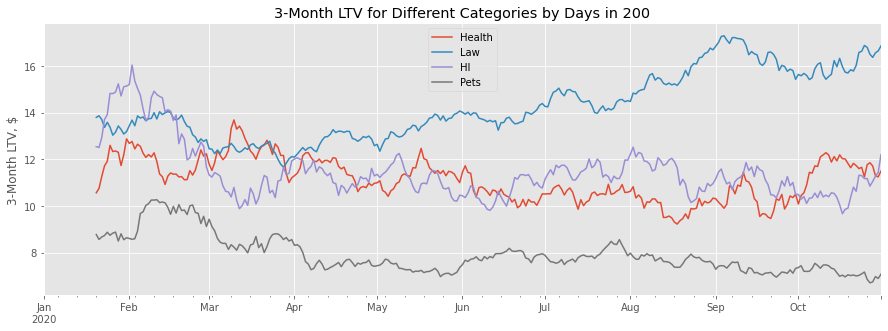

In [6]:
ppc = df.loc[df['Medium'] == 'PPC']

plot_prop(calculate_props(ppc, ['Category', 'DateCohort']), '3-Month LTV', '3-Month LTV for Different Categories by Days in 200', '3-Month LTV, $')

The 'Pets' category seems to be performing relatively bad. Let's see what might cause that.

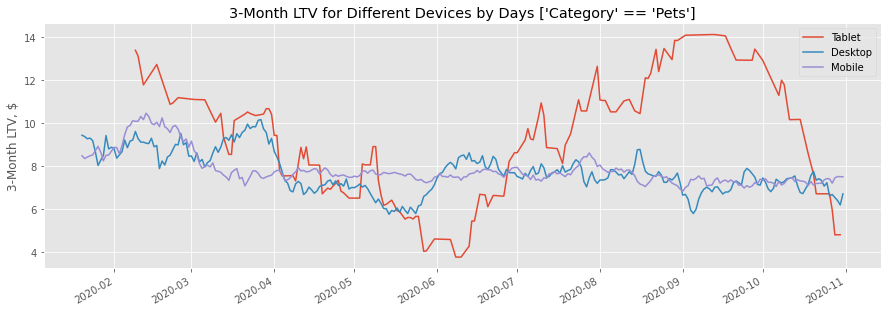

In [7]:
ppc = df.loc[df['Category'] == 'Pets']

plot_prop(calculate_props(ppc, ['Device', 'DateCohort']), '3-Month LTV', '3-Month LTV for Different Devices by Days [\'Category\' == \'Pets\']', '3-Month LTV, $')

Seems like desktop and tablet users start bringing less money. Let's see what the results are for different mediums.

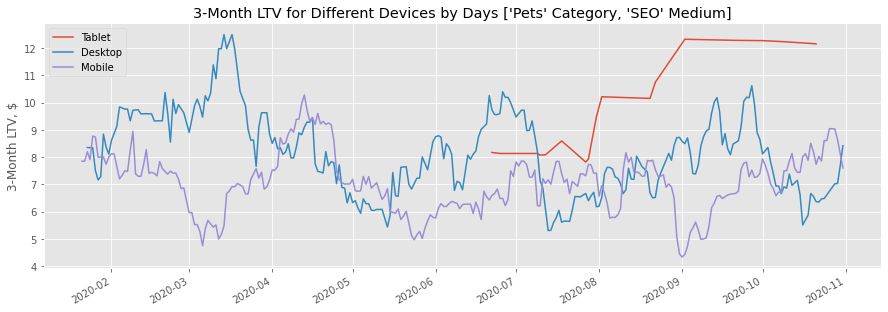

In [8]:
ppc = df.loc[(df['Category'] == 'Pets') & (df['Medium'] == 'SEO')]

plot_prop(calculate_props(ppc, ['Device', 'DateCohort']), '3-Month LTV', '3-Month LTV for Different Devices by Days [\'Pets\' Category, \'SEO\' Medium]', '3-Month LTV, $')

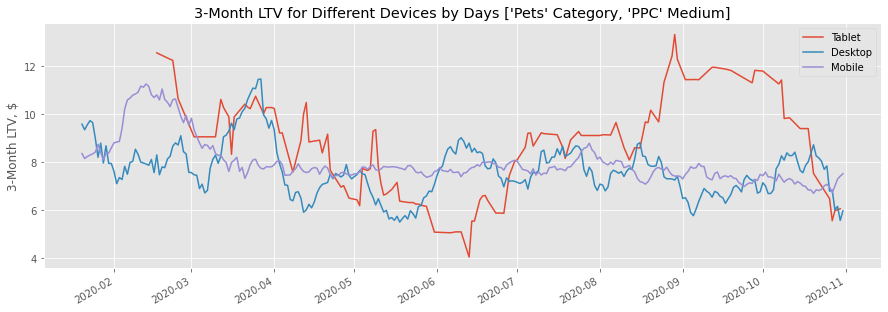

In [9]:
ppc = df.loc[(df['Category'] == 'Pets') & (df['Medium'] == 'PPC')]

plot_prop(calculate_props(ppc, ['Device', 'DateCohort']), '3-Month LTV', '3-Month LTV for Different Devices by Days [\'Pets\' Category, \'PPC\' Medium]', '3-Month LTV, $')

There is a huge decline in LTV for desktops and phones, particularly for ‘PPC’ Medium. LTV seems to be stable for mobile customers, though it is still gradually declining.

Conclusion: The company’s PPC strategy for the ‘Pets’ category should definitely be improved in the near future in order to increase LTV.

## Calculate Prediction Coefficient

In [10]:
# Create a DataFrame with payments info
payments = pd.DataFrame(index=[f'M{month}' for month in range(1, 13)])

prices = []
users = []

for month in range(1, 13):
    prices.append(df[f'M{month}Pay'].mean())
    users.append(df.loc[df[f'M{month}Pay'] > 0].shape[0])
    
payments['Price'] = prices
payments['Users'] = users

payments['Payments per Member'] = payments['Users'] / payments.loc['M1', 'Users']

# Display the DataFrame
payments

,Price,Users,Payments per Member
M1,6.140910,15066,1.000000
M2,2.421090,6778,0.449887
M3,1.806896,5062,0.335988
M4,1.246968,3524,0.233904
M5,0.928669,2614,0.173503
M6,0.688053,1944,0.129032
M7,0.504890,1433,0.095115
M8,0.366771,1035,0.068698
M9,0.242646,688,0.045666
M10,0.149968,415,0.027545


In [11]:
# Calculate the retention and available payments
retention = payments['Payments per Member'].sum()
available_payments = payments.iloc[:3, :]['Payments per Member'].sum()

retention, available_payments

(2.5835656444975434, 1.785875481215983)

In [12]:
# Calculate the prediction coefficient
prediction_coefficient = retention / available_payments

prediction_coefficient

1.4466661711142492